# THEORY SECTION: Memory in LLM Applications ---

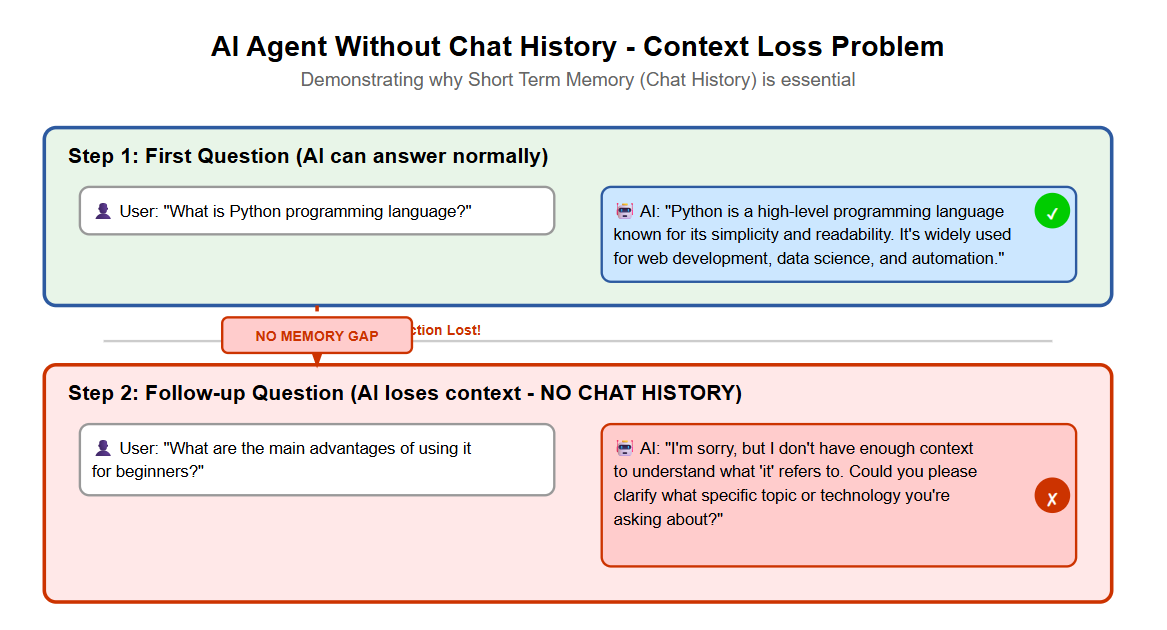


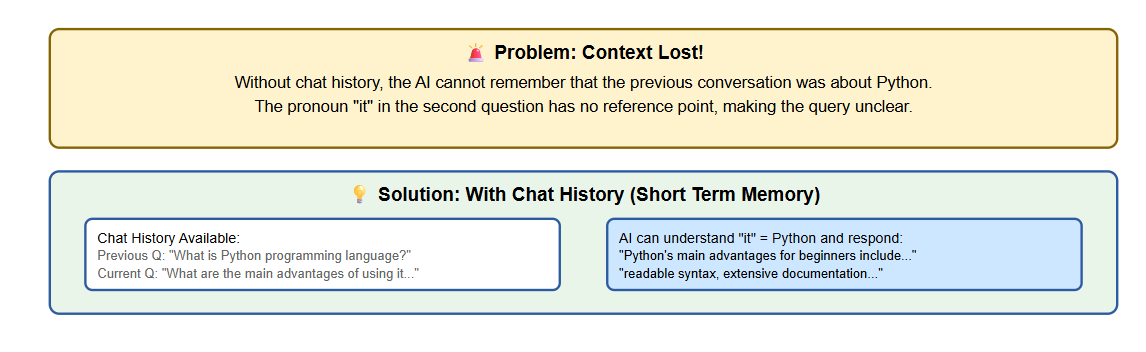

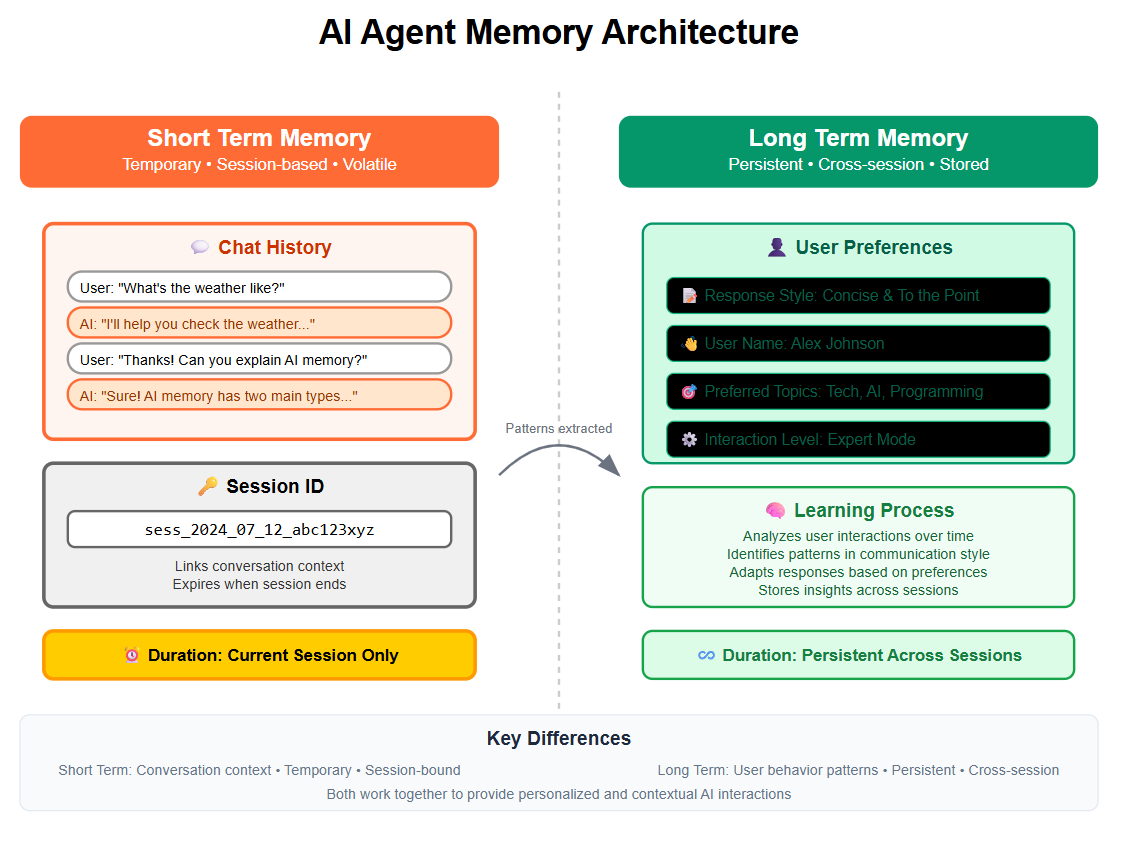

## 🔹 Short-Term Memory

Short-term memory refers to the temporary context held during an active conversation session.
This enables models to follow the flow of conversation, resolve references like pronouns (e.g., "she", "it"),
and generate responses that depend on what was said earlier.

In LangChain, this is typically managed using `RunnableWithMessageHistory`, which maintains a local memory context
for a single session, enabling conversational continuity.


Query -> Embedding -> Vector Store -> Relevant Context -> LLM

what is python  -> Rag -> Ans

Chat history
Tell me more about Python  -> Rag -> Proper Ans






# 🔹 Long-Term Memory

Long-term memory refers to persistent storage of user-specific or domain-specific facts that the system can recall across sessions.
It is useful for storing:
- User preferences (e.g., prefers concise responses)
- Profile information (e.g., user's job, interests)
- Application-specific knowledge (e.g., HR policy, product catalog)

In practice, it's implemented using vector databases like FAISS, Chroma, or Pinecone.


# 🔹 Session ID: What and Why?

A `session_id` uniquely identifies a user or chat instance in memory-based systems.
It ensures that the short-term memory (i.e., chat history) is isolated between users.

Benefits:
- Maintains context across multiple turns in a session
- Prevents memory leakage between different users
- Essential in multi-user applications like customer service, chatbots, or collaborative tools


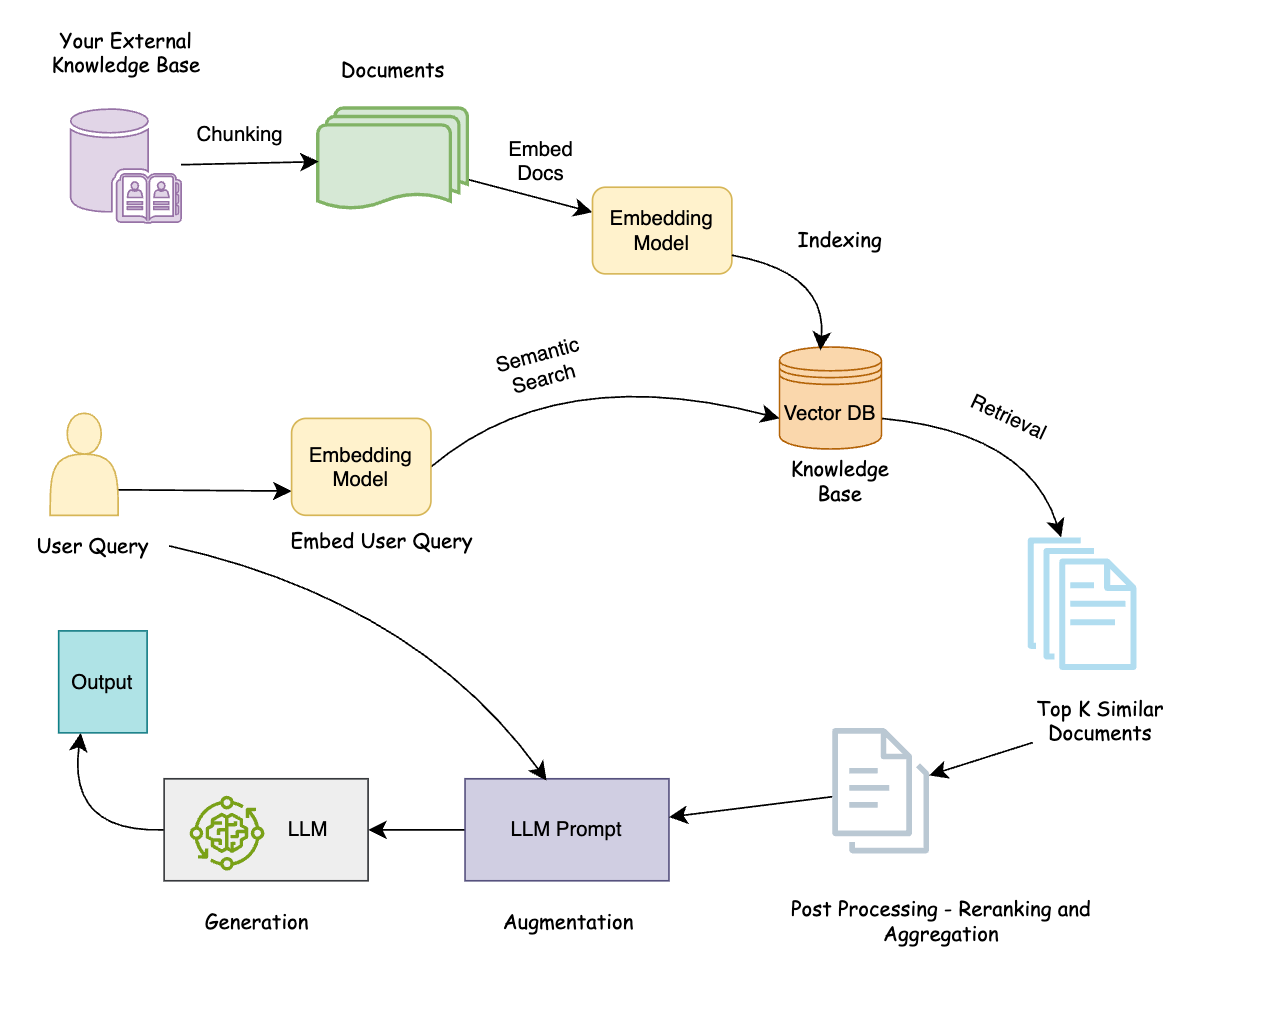

In [ ]:
Question -> Re Write (It -> Python ) -> Embedding Model -> VectorStore -> RAG -> Answer

# RAG with Short-Term and Long-Term Memory using LangChain and OpenAI (GitHub-hosted)

# --- Imports and Setup ---

In [ ]:
# Install necessary packages
!pip install langchain langchain-openai faiss-cpu sentence-transformers transformers langchain-core --quiet

In [ ]:
# --- Imports and Setup ---
import os
from langchain_openai import ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.messages import HumanMessage
from langchain_community.chat_message_histories import ChatMessageHistory

In [ ]:
# --- 1. OpenAI Model Setup (via GitHub-hosted endpoint) ---
# NOTE: Secure your token. Never expose it in production or public code.
os.environ['GITHUB_TOKEN'] = ""
token = os.environ.get("GITHUB_TOKEN")
endpoint = "https://models.github.ai/inference"
model_name = "openai/gpt-4.1-nano"

if not token:
    raise ValueError("GITHUB_TOKEN environment variable not set. Please provide a valid token.")

llm = ChatOpenAI(
    model_name=model_name,
    openai_api_key=token,
    openai_api_base=endpoint,
    temperature=0.5,

)


In [ ]:
# --- 2. Document Store & Retriever Setup ---
docs = [
    "ACME Corp is a global leader in AI-powered logistics solutions.",
    "Founded in 1998, the company now operates in over 40 countries.",
    "ACME's CEO is Jane Doe, who took over leadership in 2017.",
    "The company acquired Robotix Inc. in 2022 to boost robotics automation.",
    "Its flagship product is an intelligent route optimization engine.",
    "ACME supports more than 5,000 enterprise logistics clients worldwide.",
    "ACME is headquartered in New York, with major offices in Berlin and São Paulo.",
    "The company emphasizes sustainability and achieved ISO 14001 certification in 2023.",
    "Jane Doe is known for her vision in ethical AI and sustainability practices.",
    "ACME is expanding operations in South America and Southeast Asia as of 2024."
]

In [ ]:
embedder = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
retriever = FAISS.from_texts(docs, embedder).as_retriever(search_kwargs={"k": 3})

/tmp/ipython-input-5-1975029896.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# --- 3. Stateless RAG Chain (No Memory) ---


qa_prompt_no_memory = ChatPromptTemplate.from_template(
    """Answer the user's question based only on the following context:

<context>
{context}
</context>

Question: {input}"""
)

document_chain = create_stuff_documents_chain(llm, qa_prompt_no_memory)
rag_chain_no_memory = create_retrieval_chain(retriever, document_chain)

In [ ]:
query_1 = "Tell me about ACME's CEO."
response = rag_chain_no_memory.invoke({"input": query_1})
print("Q:", query_1)
print("A:", response["answer"])

Q: Tell me about ACME's CEO.
A: ACME's CEO is Jane Doe, who has been in leadership since 2017.


In [ ]:
query_2 = "what is my last question"
response = rag_chain_no_memory.invoke({"input": query_2})
print("\nQ:", query_2)
print("A:", response["answer"])



Q: what is my last question
A: Your last question was: "Answer the user's question based only on the following context:"


In [ ]:
# --- 4. Stateful RAG Chain (With Memory) ---
print("\n--- 4. Testing RAG Chain WITH Memory ---")


--- 4. Testing RAG Chain WITH Memory ---


In [ ]:
contextualize_q_prompt = ChatPromptTemplate.from_messages([
    ("system", "Given a chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is."),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])


QUestion Rewrite -> What is python > What is python



Question Rewrite -> Explain more about it -> Explain more about python

Rag Crucial Step -> User QUestion Rewrite

What is C++ and Why do we use Function in  Python  -> Rag c++

Tell me about Dov Soup -> Vector search + Keyword Based Search ( Dove

What is C++ -> Chunk -> 3
Why do we use Function in Python -> Chunk 3 Query Transformation

1. Query Transformation
2. Keyboard Based Search

Trust -> Question ->Chat History



In [ ]:
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


In [ ]:

qa_prompt_with_memory = ChatPromptTemplate.from_messages([
    ("system", "You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n\nContext: {context}"),
    MessagesPlaceholder("chat_history"),
    ("human", "{input}"),
])


history_aware_retriever -> QUestion -> Rewrite -> Vector SEarch -> 3 context Chunk
3 context+ Chat history + input -> Ans

Chat history 4 , Summary

Deadline -> Support

In [ ]:
qa_chain_with_memory = create_stuff_documents_chain(llm, qa_prompt_with_memory)
conversational_rag_chain = create_retrieval_chain(history_aware_retriever, qa_chain_with_memory)

In [ ]:
class SessionHistoryManager:
    def __init__(self):
        self.store = {}

    def get_history(self, session_id: str) -> ChatMessageHistory:
        if session_id not in self.store:
            self.store[session_id] = ChatMessageHistory()
        return self.store[session_id]

history_manager = SessionHistoryManager()

In [ ]:
conversational_chain_with_history = RunnableWithMessageHistory(
    conversational_rag_chain,
    history_manager.get_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)


In [ ]:

res1 = conversational_chain_with_history.invoke(
    {"input": "Tell me about ACME's CEO."},
    config={"configurable": {"session_id": "user123"}}
)
print("Q:", query_1)
print("A:", res1['answer'])

Q: Tell me about ACME's CEO.
A: ACME's CEO is Jane Doe, who became the leader of the company in 2017. There is no additional information provided about her background or role.


In [ ]:
res2 = conversational_chain_with_history.invoke(
    {"input": "what is my last question"},
    config={"configurable": {"session_id": "user123"}}
)
print("\nQ:", query_2)
print("A:", res2['answer'])



Q: what is my last question
A: Your last question was: "Tell me about ACME's CEO."


In [ ]:
res3 = conversational_chain_with_history.invoke(
    {"input": "what is my last question"},
    config={"configurable": {"session_id": "user123"}}
)
print("\nQ:", "what is my last question")
print("A:", res3['answer'])



Q: what is my last question
A: Your last question was: "what is my last question."


In [ ]:
# --- 5. Long-Term Memory (User Preferences Example) ---
print("\n--- 5. Long-Term Memory Hint Example ---")



user_facts = ["User prefers concise answers.", "User works in logistics."]
ltm_retriever = FAISS.from_texts(user_facts, embedder).as_retriever()
ltm_docs = ltm_retriever.invoke("What format should I answer in?")
print("Retrieved user preference:", ltm_docs[0].page_content)



--- 5. Long-Term Memory Hint Example ---
Retrieved user preference: User prefers concise answers.
